In [13]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from sagemaker.s3 import S3Downloader
from sklearn.model_selection import train_test_split

sys.path.append(os.path.dirname(os.getcwd()))
from src.model_utils import *

## S3

In [14]:
s3_bucket = "yang-ml-sagemaker"
s3_key = "mnist"

In [15]:
data_handler = DataHandler(s3_bucket, s3_key)
data_handler

DataHandler(bucket = yang-ml-sagemaker, key = mnist)

## Data 

In [16]:
train = data_handler.download(object_key="raw-data/train.npy")
labels = data_handler.download(object_key="raw-data/labels.npy")

train.shape, labels.shape

((60000, 28, 28), (60000,))

### Quick Visulization

In [22]:
mapping = {
    k: v
    for k, v in zip(
        np.unique(labels),
        [
            "T-shirt/top",
            "Trouser",
            "Pullover",
            "Dress",
            "Coat",
            "Sandal",
            "Shirt",
            "Sneaker",
            "Bag",
            "Ankle boot",
        ],
    )
}

The label is Trouser



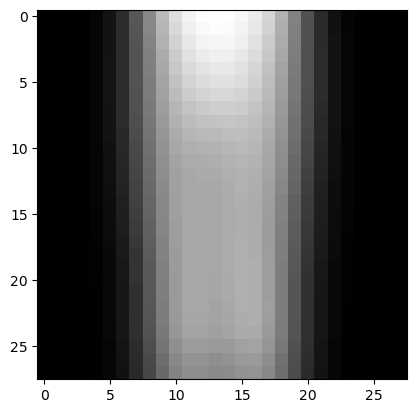

The label is Bag



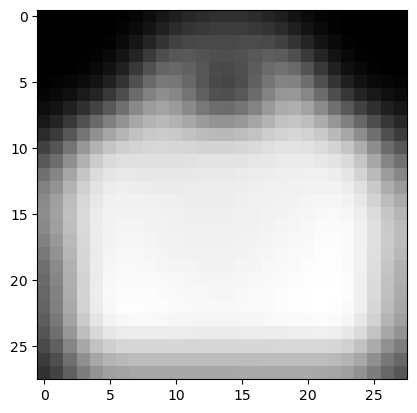

The label is Dress



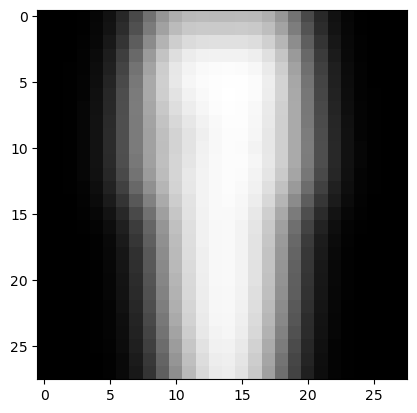

The label is Pullover



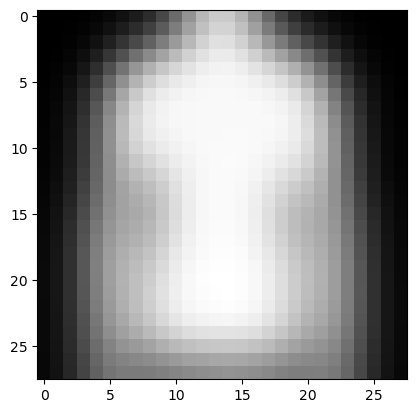

The label is Trouser



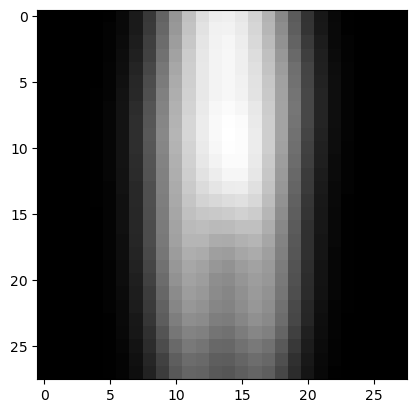

In [7]:
for i in np.random.randint(low=0, high=train.shape[0], size=5):
    print(f"The label is {mapping[labels[i]]}\n")
    plt.imshow(train[i], cmap="gray")
    plt.show()

### Train Validation Split

First, check the class distribution:

In [24]:
class_freq = (np.unique(labels, return_counts=True)[1] / labels.shape[0]) * 100
{k: f"{round(v, 2)} %" for k, v in zip(mapping.values(), class_freq)}

{'T-shirt/top': '9.96 %',
 'Trouser': '10.0 %',
 'Pullover': '10.06 %',
 'Dress': '10.04 %',
 'Coat': '10.0 %',
 'Sandal': '9.97 %',
 'Shirt': '9.94 %',
 'Sneaker': '10.02 %',
 'Bag': '9.95 %',
 'Ankle boot': '10.07 %'}

The class distributions are well balanced, so we can simple use random splitting.

In [20]:
X_train, X_val, y_train, y_val = train_test_split(
    train[:1500], labels[:1500], test_size=0.2, shuffle=True
)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1200, 28, 28), (300, 28, 28), (1200,), (300,))

Check class distributions after splitting:

In [23]:
train_class_freq = (np.unique(y_train, return_counts=True)[1] / y_train.shape[0]) * 100
print("Train labels class distribution\n")
{k: f"{round(v, 2)} %" for k, v in zip(mapping.values(), train_class_freq)}

Train labels class distribution



{'T-shirt/top': '10.5 %',
 'Trouser': '10.83 %',
 'Pullover': '10.33 %',
 'Dress': '9.25 %',
 'Coat': '9.75 %',
 'Sandal': '11.08 %',
 'Shirt': '9.33 %',
 'Sneaker': '8.58 %',
 'Bag': '10.25 %',
 'Ankle boot': '10.08 %'}

In [25]:
val_class_freq = (np.unique(y_val, return_counts=True)[1] / y_val.shape[0]) * 100
print("Validation labels class distribution\n")
{k: f"{round(v, 2)} %" for k, v in zip(mapping.values(), val_class_freq)}

Validation labels class distribution



{'T-shirt/top': '11.0 %',
 'Trouser': '12.67 %',
 'Pullover': '12.0 %',
 'Dress': '12.0 %',
 'Coat': '7.67 %',
 'Sandal': '7.33 %',
 'Shirt': '9.33 %',
 'Sneaker': '8.33 %',
 'Bag': '9.67 %',
 'Ankle boot': '10.0 %'}

## Upload to S3

In [26]:
# Take samples
data_handler.upload(object_key="train-data/X_train.npy", array=X_train)
data_handler.upload(object_key="train-data/y_train.npy", array=y_train)
data_handler.upload(object_key="val-data/X_val.npy", array=X_val)
data_handler.upload(object_key="val-data/y_val.npy", array=y_val)

Check s3 bucket:

In [27]:
S3Downloader.list(s3_uri=f"s3://{s3_bucket}/{s3_key}/train-data")

['s3://yang-ml-sagemaker/mnist/train-data/X_train.npy',
 's3://yang-ml-sagemaker/mnist/train-data/y_train.npy']

In [28]:
S3Downloader.list(s3_uri=f"s3://{s3_bucket}/{s3_key}/val-data")

['s3://yang-ml-sagemaker/mnist/val-data/X_val.npy',
 's3://yang-ml-sagemaker/mnist/val-data/y_val.npy']

In [29]:
# Delete and release resources
del data_handler